In [63]:
import os
import sys
from tqdm import tqdm
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

print(os.getcwd())

import torch
import torch.nn as nn
import torchvision.transforms as T
from model.resnet18_enc_dec_with_discriminator import ResNetEncDecWithDiscrimination
from datasets_utils.dataset_class import DynamicMVTecDataset
from datasets_utils.dataset_split import split_dataset
from torch.utils.data import DataLoader
import matplotlib.pylab as plt
import random
from torch.utils.data import Dataset
from PIL import Image
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/sameerhashmi36/Documents/AVS7/anomaly_detection_computer_vision/mvtec_anomaly_detection_scipt/testing_rec_disc


In [64]:
# Data transform
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

In [65]:
dataset = DynamicMVTecDataset(good_image_dir="../../datasets/mvtec/bottle/train/good/", transform=transform, augmentations=['cutpaste'])
_, val_data = split_dataset(dataset=dataset)

In [66]:
val_loader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=4)

In [67]:

def load_trained_model(checkpoint_path, device):
    """
    Load the trained model from a checkpoint.

    Parameters:
    - checkpoint_path: Path to the saved model checkpoint.
    - device: The device to map the model to.

    Returns:
    - model: The trained model in evaluation mode.
    """
    model = ResNetEncDecWithDiscrimination().to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    return model

In [68]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and calculate the AUROC score.

    Parameters:
    - model: Trained model.
    - test_loader: DataLoader for the test dataset.
    - device: The device to perform inference on.

    Returns:
    - auroc: AUROC score for anomaly detection.
    """
    model.eval()
    anomaly_scores = []
    true_labels = []

    with torch.no_grad():
        for images, masks, labels in tqdm(test_loader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            reconstructed, anomaly_map = model(images)

            # Calculate anomaly scores (e.g., mean anomaly map value per image)
            anomaly_score = anomaly_map.view(anomaly_map.size(0), -1).mean(dim=1).cpu().numpy()

            anomaly_scores.extend(anomaly_score)
            true_labels.extend(labels.cpu().numpy())

    # Calculate AUROC
    auroc = roc_auc_score(true_labels, anomaly_scores)
    print(f"AUROC: {auroc:.4f}")
    return auroc

In [69]:
def visualize_results(model, test_loader, device, num_samples=10):
    """
    Visualize reconstructed images, anomaly maps, binary anomaly maps, and ground truth masks.

    Parameters:
    - model: Trained model.
    - test_loader: DataLoader for the test dataset.
    - device: The device to perform inference on.
    - num_samples: Number of samples to visualize.
    """
    
    model.eval()
    all_samples = list(test_loader)
    random_samples = random.sample(all_samples, min(num_samples, len(all_samples)))

    with torch.no_grad():
        for images, masks, labels in random_samples:
            images, masks = images.to(device), masks.to(device)

            reconstructed, anomaly_map = model(images)
            reconstructed = reconstructed.cpu().numpy()
            anomaly_map = anomaly_map.cpu().numpy()
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()

            # Create binary anomaly map
            binary_anomaly_map = (anomaly_map > 0.5).astype(np.uint8)  # Threshold at 0.5

            # Visualize the first sample in the batch
            plt.figure(figsize=(18, 5))
            plt.subplot(1, 5, 1)
            plt.imshow(np.transpose(images[0], (1, 2, 0)))
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(1, 5, 2)
            plt.imshow(np.transpose(reconstructed[0], (1, 2, 0)))
            plt.title("Reconstructed Image")
            plt.axis("off")

            plt.subplot(1, 5, 3)
            plt.imshow(anomaly_map[0, 0], cmap="hot")
            plt.title("Anomaly Map")
            plt.axis("off")

            plt.subplot(1, 5, 4)
            plt.imshow(binary_anomaly_map[0, 0], cmap="gray")
            plt.title("Binary Anomaly Map")
            plt.axis("off")

            plt.subplot(1, 5, 5)
            plt.imshow(masks[0, 0], cmap="gray")
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()


In [70]:
# Load trained model
checkpoint_path = "../experiments_rec_disc/experiment_01_bottle_cutpaste/checkpoints/model_epoch_96_valloss_0.0270.pth"
model = load_trained_model(checkpoint_path, device)

In [71]:
# Evaluate the model
auroc = evaluate_model(model, val_loader, device)

Evaluating: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

AUROC: 1.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09303858..1.4494555].


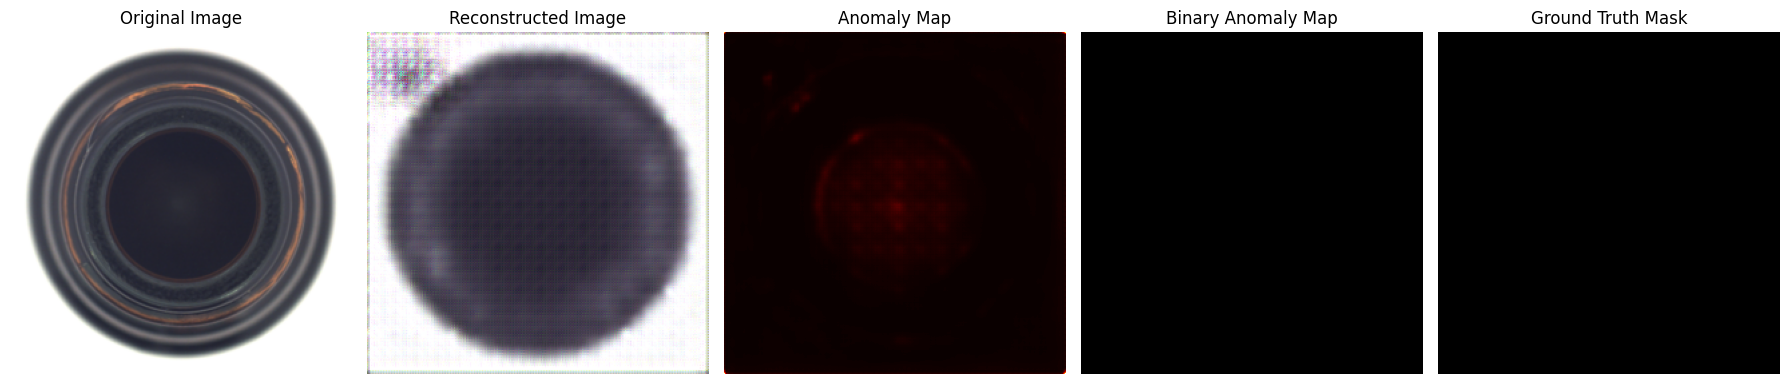

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09264816..1.431886].


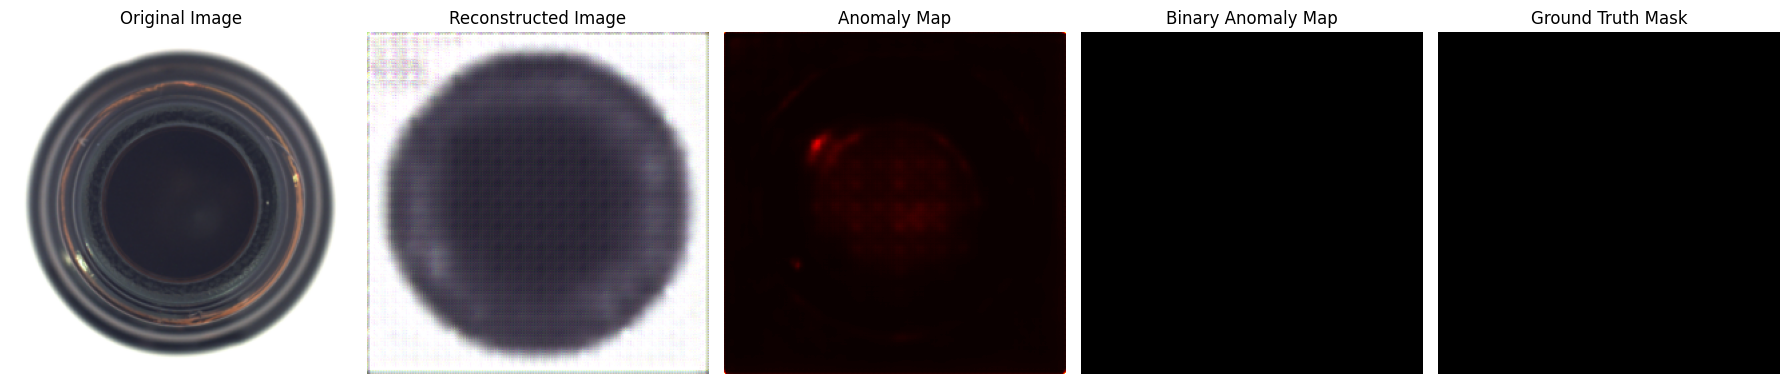

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09069689..1.42878].


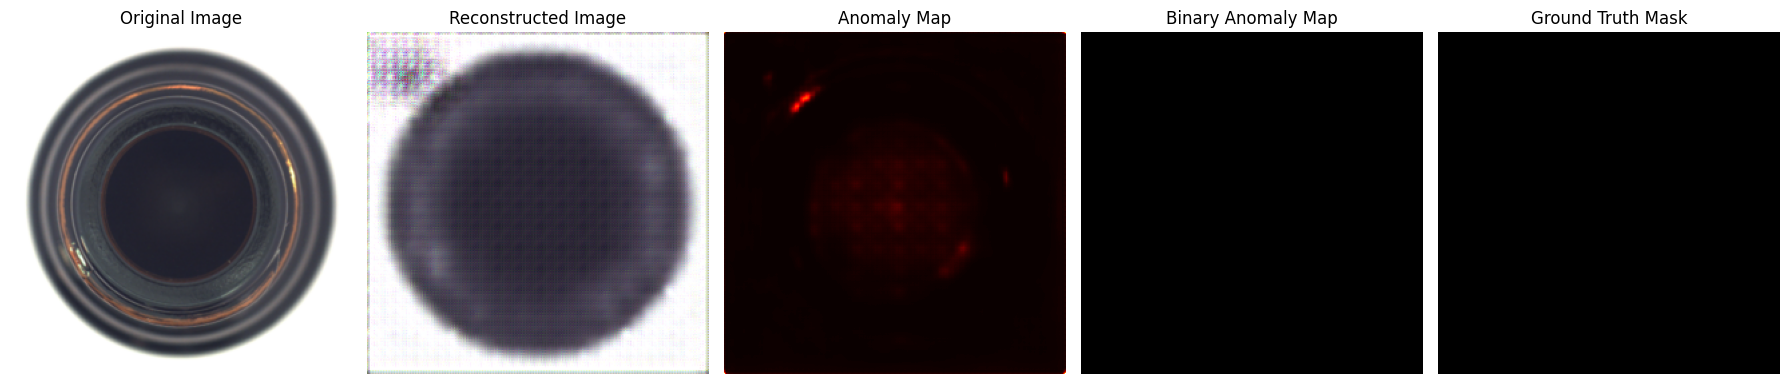

In [72]:

# Visualize random samples
visualize_results(model, val_loader, device, num_samples=3)

In [73]:
class TestingMVTecDataset(Dataset):
    def __init__(self, test_dir, ground_truth_dir, transform=None):
        """
        Custom dataset for testing MVTec data.

        Parameters:
        - test_dir: Path to the test images folder.
        - ground_truth_dir: Path to the ground truth masks folder.
        - transform: Transformations to apply to the test images.
        """
        self.test_dir = test_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform
        self.data = []

        # Iterate through all subfolders (broken_large, broken_small, contamination)
        for subfolder in os.listdir(test_dir):
            test_subfolder = os.path.join(test_dir, subfolder)
            gt_subfolder = os.path.join(ground_truth_dir, subfolder)

            if os.path.isdir(test_subfolder) and os.path.isdir(gt_subfolder):
                for img_file in os.listdir(test_subfolder):
                    if img_file.endswith(".png"):
                        test_img_path = os.path.join(test_subfolder, img_file)
                        gt_mask_path = os.path.join(gt_subfolder, img_file.replace(".png", "_mask.png"))
                        
                        # Only add entries where both test image and ground truth mask exist
                        if os.path.isfile(test_img_path) and os.path.isfile(gt_mask_path):
                            self.data.append((test_img_path, gt_mask_path))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        test_img_path, gt_mask_path = self.data[idx]

        # Load test image
        test_image = Image.open(test_img_path).convert("RGB")

        # Load ground truth mask
        ground_truth_mask = Image.open(gt_mask_path).convert("L")  # Grayscale for mask

        # Apply transformations
        if self.transform:
            test_image = self.transform(test_image)
            ground_truth_mask = self.transform(ground_truth_mask)

        return test_image, ground_truth_mask, test_img_path


In [74]:
test_image_dir = "../../datasets/mvtec/bottle/test/"
ground_truth_dir = "../../datasets/mvtec/bottle/ground_truth"

test_dataset = TestingMVTecDataset(test_dir=test_image_dir, ground_truth_dir=ground_truth_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")

Number of test samples: 63


In [75]:
# Test the model on testing images
auroc = evaluate_model(model, val_loader, device)

Evaluating: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

AUROC: 1.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06480373..1.4705489].


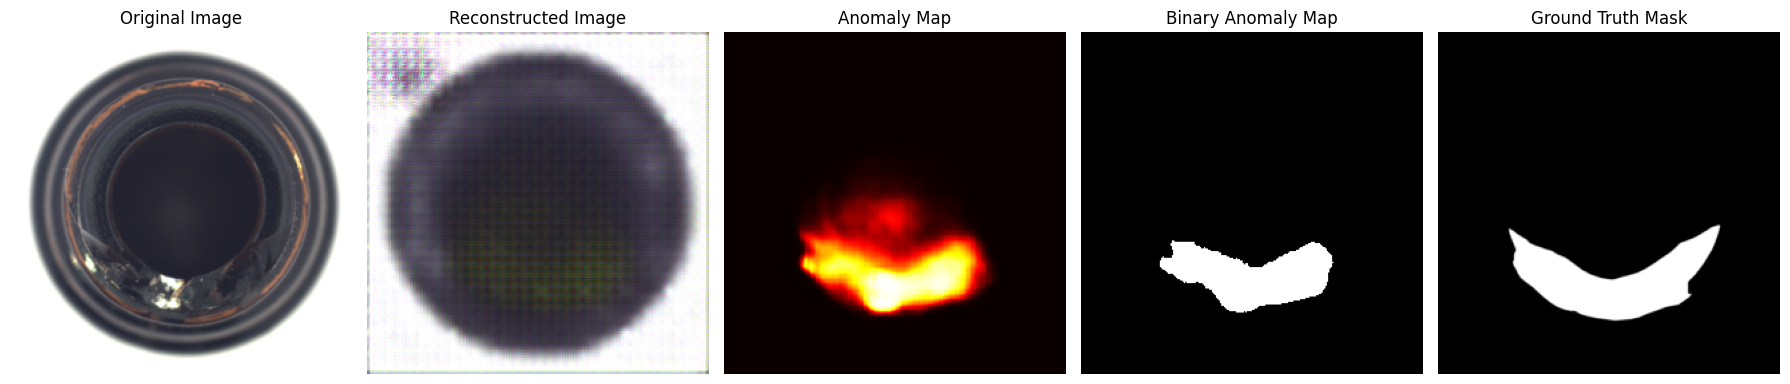

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08460657..1.4645759].


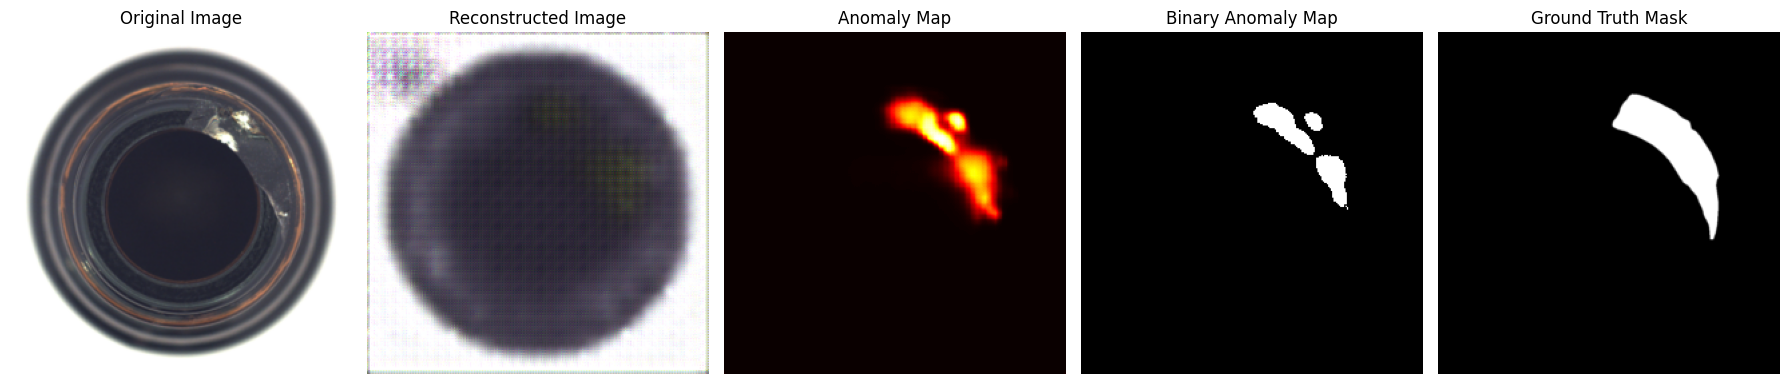

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.063018724..1.4356186].


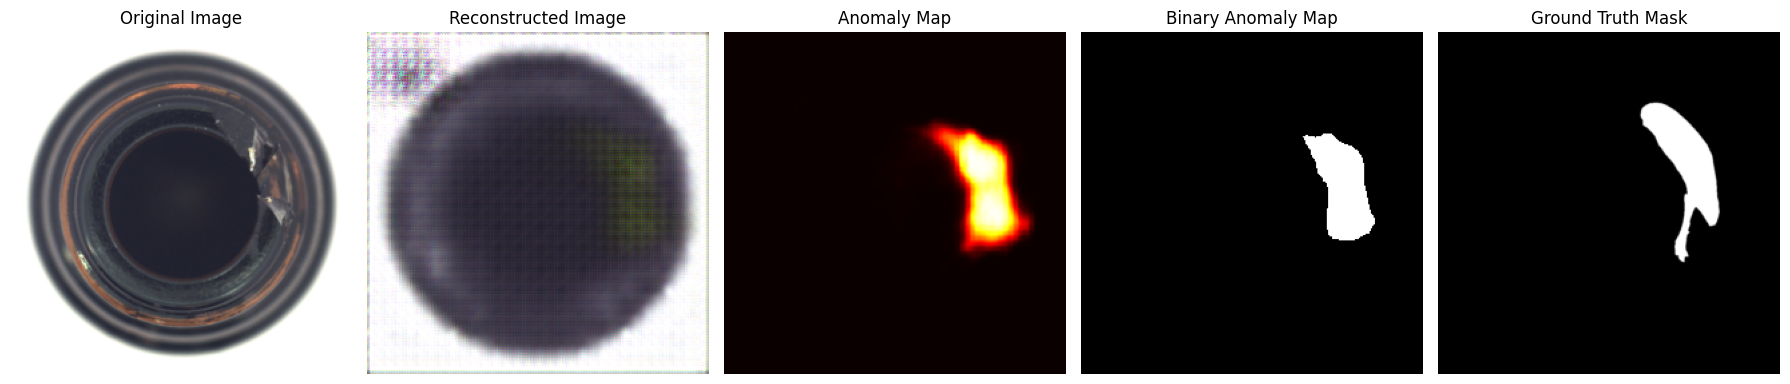

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.054066412..1.5167596].


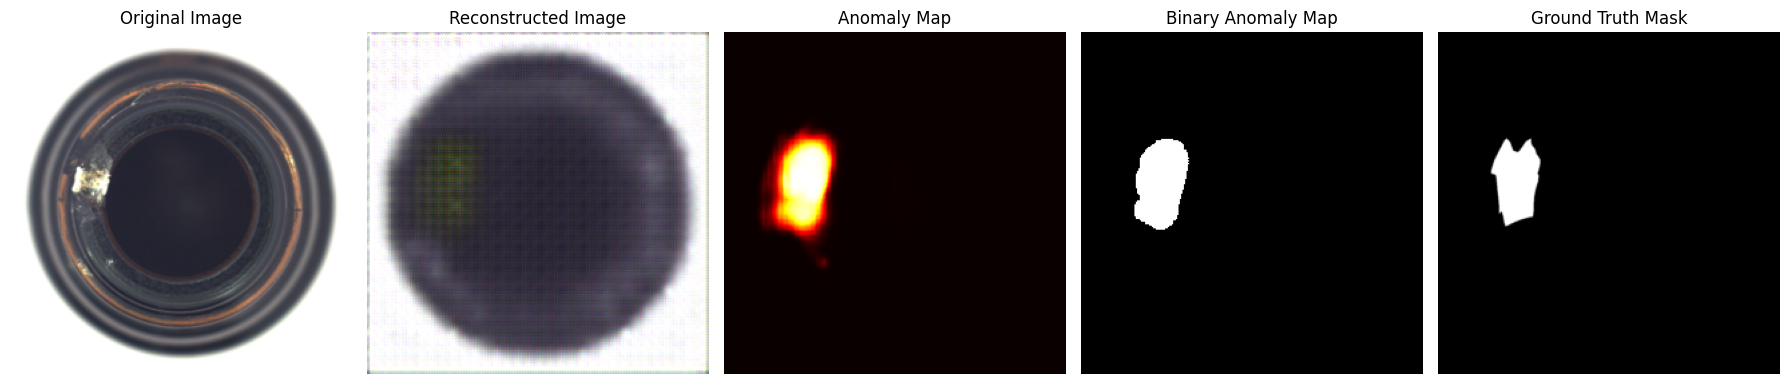

In [81]:
# Visualize random samples
visualize_results(model, test_loader, device, num_samples=4)